In [6]:
import torch as t
import matplotlib.pyplot as plt

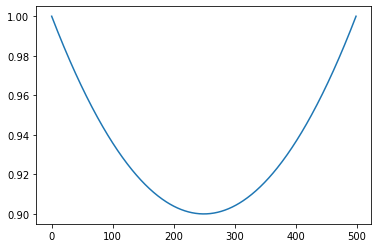

In [8]:
plt.plot(

In [105]:
NHilbert = 10
NTrot = 1000
T = 30
dt = T/NTrot*0.25

def randc(N=NHilbert):
    #return 2*(t.rand(N) - 0.5) + 2j*(t.rand(N) - 0.5)
    if type(N) == tuple:
        return t.matrix_exp(-1j*dt*t.rand(N))
    return t.exp(-1j*dt*t.rand(N))


times = t.linspace(0,T,NTrot)
alphas = (times - T/2)**2
alphas = alphas/alphas.max()*0.1 + 0.9

sqrd_dists = (times.view(-1,1) - times.view(1,-1))**2/0.1
height_weights = (1/(1+sqrd_dists)/t.sum(1/(1+sqrd_dists),1))

In [106]:
class New(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.heights = t.nn.parameter.Parameter(t.rand(NTrot))
        self.alphas = alphas
        self.height_weights = height_weights

        self.D1 = randc()
        self.D2 = randc()
        self.M3 = randc((NHilbert,NHilbert))
        self.D4 = randc()
        self.M5 = randc((NHilbert,NHilbert))

    def forward(self):
        pulse = t.sum(self.heights*self.height_weights,1)
        

        M1s = t.diag_embed(self.D1*t.pow(self.D2,pulse.view(-1,1)))
        M2s = self.M3@t.diag_embed(t.pow(self.D4,alphas.view(-1,1)))@self.M5

        return t.linalg.multi_dot(list(mat for mat in M1s@M2s))

n = New()
U = n()

In [107]:
class Classic(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.heights = t.nn.parameter.Parameter(t.rand(NTrot))
        self.alphas = alphas
        self.height_weights = height_weights

        self.M1 = randc((NHilbert,NHilbert))
        self.M2 = randc((NHilbert,NHilbert))
        self.M3 = randc((NHilbert,NHilbert))
        self.M4 = randc((NHilbert,NHilbert))

    def forward(self):
        pulse = t.sum(self.heights*self.height_weights,1)
        alphas = self.alphas


        H = self.M1.repeat(alphas.shape[0],1,1) \
            + self.M2.repeat(alphas.shape[0],1,1) \
            + alphas.view(-1,1,1)*self.M3 \
            + pulse.view(-1,1,1)*self.M4
        
        return t.linalg.multi_dot(list(mat for mat in t.matrix_exp(-1j*dt*H)))
c = Classic()
U = c()

In [108]:
from time import time
def timer(model, N=100):
    start = time()
    for i in range(N):
        model()
    print(time() - start)

In [109]:
timer(c)

129.1081771850586


In [110]:
timer(n)

146.6936755180359


In [119]:
class NewGPU(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.heights = t.nn.parameter.Parameter(t.rand(NTrot))
        self.alphas = alphas.to(t.device('cuda'))
        self.height_weights = height_weights.to(t.device('cuda'))

        self.D1 = randc().to(t.device('cuda'))
        self.D2 = randc().to(t.device('cuda'))
        self.M3 = randc((NHilbert,NHilbert)).to(t.device('cuda'))
        self.D4 = randc().to(t.device('cuda'))
        self.M5 = randc((NHilbert,NHilbert)).to(t.device('cuda'))

    def forward(self):
        pulse = t.sum(self.heights*self.height_weights,1)

        M1s = t.diag_embed(self.D1*t.pow(self.D2,pulse.view(-1,1)))
        M2s = self.M3@t.diag_embed(t.pow(self.D4,self.alphas.view(-1,1)))@self.M5

        return t.linalg.multi_dot(list(mat for mat in M1s@M2s))

ng = NewGPU().to(t.device('cuda'))

In [123]:
timer(ng)

168.49792170524597


In [140]:
def timer_diff(model,N=100,device='cpu'):
    fac = 1/NHilbert**2
    Id = t.eye(NHilbert).cfloat().to(device)
    def loss_func(U):
        return 1 - fac*t.trace(t.abs(Id@U))
    optimizer = t.optim.Adam(model.parameters(), lr=1e-2)
    start = time()
    for i in range(N):
        loss = loss_func(model())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(time() - start)

In [142]:
timer_diff(ng,20,'cuda')

30.76104497909546


In [143]:
timer_diff(n,20,'cpu')

30.557307958602905


In [144]:
timer_diff(c,20,'cpu')

30.779876470565796
